### **WHO DOES OUR MODEL HAVE EACH TEAM DRAFTING ACCORDING TO THE ANALYSTS?**

---



In [2]:
# %%
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# %%
# Initialize DataFrames
jeremiah = pd.DataFrame()
kiper = pd.DataFrame()
bucky = pd.DataFrame()
tannenbaum = pd.DataFrame()
draft_results = pd.DataFrame()

# Load mock drafts (2021–2025) and real draft results (2021–2024)
for year in ['21', '22', '23', '24', '25']:
    year_int = 2000 + int(year)

    # Load mocks
    cur_jeremiah = pd.read_csv(f'jeremiah{year}.csv')
    cur_jeremiah['year'] = year_int
    jeremiah = pd.concat([jeremiah, cur_jeremiah])

    cur_kiper = pd.read_csv(f'kiper{year}.csv')
    cur_kiper['year'] = year_int
    kiper = pd.concat([kiper, cur_kiper])

    cur_bucky = pd.read_csv(f'brooks{year}.csv')
    cur_bucky['year'] = year_int
    bucky = pd.concat([bucky, cur_bucky])

    cur_tannenbaum = pd.read_csv(f'tannenbaum{year}.csv')
    cur_tannenbaum['year'] = year_int
    tannenbaum = pd.concat([tannenbaum, cur_tannenbaum])

    # Load actual draft results only for 2021–2024
    if year != '25':
        cur_draft_results = pd.read_csv(f'nfldraft{year}.csv')
        cur_draft_results['year'] = year_int
        draft_results = pd.concat([draft_results, cur_draft_results])

# Keep relevant columns
draft_results = draft_results[['Pick', 'Tm', 'Player', 'year']]
jeremiah = jeremiah.rename(columns={'Pick': 'Pick_jeremiah'})
kiper = kiper.rename(columns={'Pick': 'Pick_kiper'})
bucky = bucky.rename(columns={'Pick': 'Pick_bucky'})
tannenbaum = tannenbaum.rename(columns={'Pick': 'Pick_tannenbaum'})

# %%
# Merge mock drafts with draft results
weighted_avg = draft_results.copy()
weighted_avg = weighted_avg.merge(jeremiah, on=['year', 'Player'], how='left', suffixes=('', '_jeremiah')) # Add suffixes here to avoid later conflicts
weighted_avg = weighted_avg.merge(kiper, on=['year', 'Player'], how='left', suffixes=('', '_kiper'))  # Add suffixes here
weighted_avg = weighted_avg.merge(bucky, on=['year', 'Player'], how='left', suffixes=('', '_bucky'))  # Add suffixes here
weighted_avg = weighted_avg.merge(tannenbaum, on=['year', 'Player'], how='left', suffixes=('', '_tannenbaum')) # Add suffixes here

# Handle missing picks using year-specific fill values
FILL_NA_BY_YEAR = {2021: 33, 2022: 33, 2023: 33, 2024: 33}
for col in ['Pick_jeremiah', 'Pick_kiper', 'Pick_bucky', 'Pick_tannenbaum']:
    weighted_avg[col] = weighted_avg.apply(
        lambda row: row[col] if pd.notna(row[col]) else FILL_NA_BY_YEAR[row['year']],
        axis=1
    )

# Drop rows with missing actual picks
weighted_avg.dropna(subset=['Pick'], inplace=True)

# %%
# Train linear regression model
X = weighted_avg[['Pick_jeremiah', 'Pick_kiper', 'Pick_bucky', 'Pick_tannenbaum']]
y = weighted_avg['Pick']
reg = LinearRegression().fit(X, y)

# Output model weights
coefficients = pd.DataFrame({
    'Source': X.columns,
    'Weight': reg.coef_
})
print("Learned Weights:")
print(coefficients.to_string(index=False))

# Evaluate model
predicted_train = reg.predict(X)
print("\nModel Performance:")
print("R²:", round(r2_score(y, predicted_train), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y, predicted_train)), 4))

# Standardized weights
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reg_scaled = LinearRegression().fit(X_scaled, y)
standardized_coefficients = pd.DataFrame({
    'Source': X.columns,
    'Standardized Weight': reg_scaled.coef_
})
print("\nStandardized Analyst Weights (after feature scaling):")
print(standardized_coefficients.to_string(index=False))

# %%
# Predict 2025 draft order
jeremiah_25 = jeremiah[jeremiah['year'] == 2025].drop(columns=['year'])
kiper_25 = kiper[kiper['year'] == 2025].drop(columns=['year'])
bucky_25 = bucky[bucky['year'] == 2025].drop(columns=['year'])
tannenbaum_25 = tannenbaum[tannenbaum['year'] == 2025].drop(columns=['year'])

# Merge all mocks for 2025
all_mocks_25 = jeremiah_25.merge(kiper_25, on='Player', how='outer', suffixes=('_jeremiah', '_kiper'))
all_mocks_25 = all_mocks_25.merge(bucky_25, on='Player', how='outer', suffixes=('', '_bucky'))
all_mocks_25 = all_mocks_25.merge(tannenbaum_25, on='Player', how='outer', suffixes=('', '_tannenbaum'))

# Fill missing mock picks for 2025
FILL_NA_PICK_2025 = 33
for col in ['Pick_jeremiah', 'Pick_kiper', 'Pick_bucky', 'Pick_tannenbaum']:
    all_mocks_25[col] = all_mocks_25[col].fillna(FILL_NA_PICK_2025)

# Predict 2025 pick positions
all_mocks_25['predicted_raw'] = reg.predict(
    all_mocks_25[['Pick_jeremiah', 'Pick_kiper', 'Pick_bucky', 'Pick_tannenbaum']]
)
all_mocks_25['predicted'] = all_mocks_25['predicted_raw'].rank()
all_mocks_25.sort_values(by='predicted', inplace=True)

# Round predicted ranks to nearest integer
all_mocks_25['predicted_round'] = all_mocks_25['predicted'].round().astype(int)

#Load 2025 team draft order
draft_order_2025 = pd.read_csv('nfldraft25.csv')
if 'Tm' in draft_order_2025.columns and 'Abbreviation' not in draft_order_2025.columns:
    draft_order_2025.rename(columns={'Tm': 'Abbreviation'}, inplace=True)

# Merge to assign team abbreviations based on predicted pick
all_mocks_25 = all_mocks_25.merge(
    draft_order_2025[['Pick', 'Abbreviation']],
    left_on='predicted_round',
    right_on='Pick',
    how='left'
).drop(columns=['Pick'])

all_mocks_25['Tm'] = all_mocks_25['Abbreviation']
all_mocks_25.drop(columns=['Abbreviation', 'predicted_round'], inplace=True)

# 🔽 Only keep top 32 predicted picks
top_32 = all_mocks_25[all_mocks_25['predicted'] <= 32].copy()
top_32.sort_values(by='predicted', inplace=True)

# Display results
print("\n2025 Predicted Draft Order (Top 32 Only):")
print(
    top_32[
        ['Player', 'Tm', 'predicted', 'Pick_jeremiah', 'Pick_kiper', 'Pick_bucky', 'Pick_tannenbaum']
    ].to_string(index=False)
)


Learned Weights:
         Source   Weight
  Pick_jeremiah 2.342850
     Pick_kiper 1.347919
     Pick_bucky 1.396471
Pick_tannenbaum 1.424453

Model Performance:
R²: 0.2451
RMSE: 65.0571

Standardized Analyst Weights (after feature scaling):
         Source  Standardized Weight
  Pick_jeremiah            14.374058
     Pick_kiper             8.261218
     Pick_bucky             8.237100
Pick_tannenbaum             8.426528

2025 Predicted Draft Order (Top 32 Only):
            Player  Tm  predicted  Pick_jeremiah  Pick_kiper  Pick_bucky  Pick_tannenbaum
          Cam Ward TEN        1.0            2.0         2.0         1.0              1.0
      Abdul Carter CLE        2.0            1.0         1.0         4.0              5.0
     Travis Hunter NYG        3.0            3.0         3.0         3.0              2.0
      Mason Graham  NE        4.0            5.0         5.0         5.0              3.0
     Will Campbell JAX        5.0            4.0         4.0         9.0        

# **Mock Drafts vs Actual Draft 2024**

In [3]:
import pandas as pd
import numpy as np
import re
#Function to normalize player names (handles Jr, Sr, etc., punctuation, and spacing)
def normalize_name(name):
    if pd.isna(name):
        return ''
    name = name.replace('.', '').replace(',', '').strip()
    name = re.sub(r'\s+', ' ', name)  # Collapse multiple spaces
    # Remove common suffixes at the end of names
    for suffix in [' Jr', ' Sr', ' II', ' III', ' IV']:
        if name.endswith(suffix):
            name = name[:-len(suffix)].strip()
    return name.lower()

#Load actual 2024 draft results (limit to first round)
draft_2024 = pd.read_csv('nfldraft24.csv')[['Player', 'Tm', 'Pick']]
draft_2024 = draft_2024[draft_2024['Pick'] <= 32]
draft_2024['year'] = 2024
draft_2024['Player_clean'] = draft_2024['Player'].apply(normalize_name)

#Load final mock drafts for 2024 and normalize names
jeremiah_24 = pd.read_csv('jeremiah24.csv')[['Player', 'Pick']].rename(columns={'Pick': 'Pick_jeremiah'})
jeremiah_24['Player_clean'] = jeremiah_24['Player'].apply(normalize_name)

kiper_24 = pd.read_csv('kiper24.csv')[['Player', 'Pick']].rename(columns={'Pick': 'Pick_kiper'})
kiper_24['Player_clean'] = kiper_24['Player'].apply(normalize_name)

bucky_24 = pd.read_csv('brooks24.csv')[['Player', 'Pick']].rename(columns={'Pick': 'Pick_bucky'})
bucky_24['Player_clean'] = bucky_24['Player'].apply(normalize_name)

tannenbaum_24 = pd.read_csv('tannenbaum24.csv')[['Player', 'Pick']].rename(columns={'Pick': 'Pick_tannenbaum'})
tannenbaum_24['Player_clean'] = tannenbaum_24['Player'].apply(normalize_name)

#Merge mock drafts with actual picks using cleaned names
compare_df = draft_2024.copy()
compare_df = compare_df.merge(jeremiah_24[['Player_clean', 'Pick_jeremiah']], on='Player_clean', how='left')
compare_df = compare_df.merge(kiper_24[['Player_clean', 'Pick_kiper']], on='Player_clean', how='left')
compare_df = compare_df.merge(bucky_24[['Player_clean', 'Pick_bucky']], on='Player_clean', how='left')
compare_df = compare_df.merge(tannenbaum_24[['Player_clean', 'Pick_tannenbaum']], on='Player_clean', how='left')

#Calculate delta between actual pick and mock drafts
for analyst in ['jeremiah', 'kiper', 'bucky', 'tannenbaum']:
    pick_col = f'Pick_{analyst}'
    delta_col = f'Delta_{analyst}'
    compare_df[delta_col] = compare_df.apply(
        lambda row: abs(row['Pick'] - row[pick_col]) if not pd.isna(row[pick_col]) else None,
        axis=1
    )

#Clean up
compare_df.drop(columns=['Player_clean'], inplace=True)

#Display results
compare_df.sort_values(by='Pick', inplace=True)
print("\n📊 2024 FIRST ROUND: Analyst Mock Comparison vs Actual Draft")
print(compare_df[[
    'Tm', 'Player', 'Pick',
    'Pick_jeremiah',
    'Pick_kiper',
    'Pick_bucky',
    'Pick_tannenbaum'
]].to_string(index=False))


📊 2024 FIRST ROUND: Analyst Mock Comparison vs Actual Draft
 Tm              Player  Pick  Pick_jeremiah  Pick_kiper  Pick_bucky  Pick_tannenbaum
CHI      Caleb Williams     1            1.0         1.0         1.0              1.0
WAS      Jayden Daniels     2            2.0         2.0         2.0              3.0
NWE          Drake Maye     3            3.0         3.0        11.0              2.0
ARI Marvin Harrison Jr.     4            4.0         4.0         4.0              9.0
LAC             Joe Alt     5            7.0         7.0         5.0              5.0
NYG        Malik Nabers     6            6.0         6.0         6.0              6.0
TEN           JC Latham     7            5.0        11.0        14.0              7.0
ATL       Michael Penix     8           13.0         NaN         NaN             19.0
CHI         Rome Odunze     9           10.0         9.0         9.0             14.0
MIN       J.J. McCarthy    10           11.0         5.0         3.0           

# **Ranking each analyst by the accuracy of their predictions compared to where the player was actually drafted.**

In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Load data for 2022–2024 only
years = ['22', '23', '24']
analysts = ['jeremiah', 'kiper', 'bucky', 'tannenbaum']
FILL_NA = 33

# Load and stack all data
dfs = {a: [] for a in analysts}
draft_results = []

for year in years:
    y_int = 2000 + int(year)

    # Actual draft results
    df_draft = pd.read_csv(f'nfldraft{year}.csv')[['Player', 'Tm', 'Pick']]
    df_draft['year'] = y_int
    draft_results.append(df_draft)

    # Load mocks
    for a in analysts:
        # Use 'brooks' instead of 'bucky' in the filename for Bucky Brooks' data
        if a == 'bucky':
            df = pd.read_csv(f'brooks{year}.csv')[['Player', 'Pick']]
        else:
            df = pd.read_csv(f'{a}{year}.csv')[['Player', 'Pick']]
        df['year'] = y_int
        df = df.rename(columns={'Pick': f'Pick_{a}'})
        dfs[a].append(df)

# Combine all
draft_results = pd.concat(draft_results)
df_all = draft_results.copy()
for a in analysts:
    df_mock = pd.concat(dfs[a])
    df_all = df_all.merge(df_mock, on=['Player', 'year'], how='left')

# Fill missing mock picks with 33 (early 2nd round)
for a in analysts:
    df_all[f'Pick_{a}'] = df_all[f'Pick_{a}'].fillna(FILL_NA)

# --- Accuracy Scoring ---
print("\n📊 Year-by-Year Analyst Accuracy Rankings:\n")
for year in [2022, 2023, 2024]:
    df_y = df_all[df_all['year'] == year]
    rows = []
    for a in analysts:
        deltas = abs(df_y['Pick'] - df_y[f'Pick_{a}'])
        correct = (deltas == 0).sum()
        total_delta = deltas.sum()
        weighted = correct * 1000 - total_delta
        rows.append({
            'Analyst': a.capitalize(),
            'Correct Picks': correct,
            'Total Delta': total_delta,
            'Weighted Score': weighted
        })
    ranked = pd.DataFrame(rows).sort_values(by=['Weighted Score', 'Total Delta'], ascending=[False, True])
    ranked['Rank'] = range(1, len(ranked) + 1)
    print(f"====== Year: {year} ======")
    print(ranked[['Rank', 'Analyst', 'Correct Picks', 'Total Delta', 'Weighted Score']].to_string(index=False))
    print("\n")

# --- Linear Regression to evaluate predictive accuracy ---
X = df_all[[f'Pick_{a}' for a in analysts]]
y = df_all['Pick']
reg = LinearRegression().fit(X, y)

print("📐 Linear Regression Coefficients (Unscaled):")
print(pd.DataFrame({
    'Analyst': [a.capitalize() for a in analysts],
    'Weight (Unscaled)': reg.coef_
}).to_string(index=False))

# Model performance
preds = reg.predict(X)
rmse = np.sqrt(mean_squared_error(y, preds))
r2 = r2_score(y, preds)
print(f"\n📊 Model Performance:\nR² Score: {r2:.4f}\nRMSE: {rmse:.2f} picks")

# --- Standardized coefficients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reg_scaled = LinearRegression().fit(X_scaled, y)
print("\n📐 Standardized Coefficients (Fair Comparison):")
print(pd.DataFrame({
    'Analyst': [a.capitalize() for a in analysts],
    'Standardized Weight': reg_scaled.coef_
}).to_string(index=False))


📊 Year-by-Year Analyst Accuracy Rankings:

====== Year: 2022 ======
 Rank    Analyst  Correct Picks  Total Delta  Weighted Score
    1      Kiper              7      26498.0        -19498.0
    2   Jeremiah              4      26502.0        -22502.0
    3 Tannenbaum              3      26645.0        -23645.0
    4      Bucky              2      26589.0        -24589.0


====== Year: 2023 ======
 Rank    Analyst  Correct Picks  Total Delta  Weighted Score
    1      Bucky              6      25945.0        -19945.0
    2   Jeremiah              5      25963.0        -20963.0
    3 Tannenbaum              3      26039.0        -23039.0
    4      Kiper              1      25951.0        -24951.0


====== Year: 2024 ======
 Rank    Analyst  Correct Picks  Total Delta  Weighted Score
    1      Kiper              9      25419.0        -16419.0
    2 Tannenbaum              8      25455.0        -17455.0
    3   Jeremiah              7      25380.0        -18380.0
    4      Bucky       

## **Pre vs Post Combine Mocks (Mel Kiper)**



In [5]:
import pandas as pd
import os

def analyze_mock_movements(analyst: str, years):
    """
    Analyze pre- vs post-combine mock draft differences for a given analyst.

    Args:
        analyst (str): Analyst name (e.g., 'kiper').
        years (list): List of years to analyze.

    Returns:
        tuple: (all_changes_df, same_position_df)
    """
    all_changes = []
    all_same_position = []

    for year in years:
        short_year = str(year)[2:]
        pre_file = f"{analyst}{short_year}(pre-combine).csv"
        final_file = f"{analyst}{short_year}.csv"

        if not os.path.exists(pre_file) or not os.path.exists(final_file):
            print(f"⚠️ Missing files for {analyst} {year}. Skipping.")
            continue

        # Load data
        pre_df = pd.read_csv(pre_file)
        final_df = pd.read_csv(final_file)

        # Merge and compute difference
        merged = pd.merge(pre_df, final_df, on="Player", suffixes=("_pre", "_final"), how="outer")
        merged["Pick_Difference"] = abs(merged["Pick_pre"] - merged["Pick_final"])
        merged["Year"] = year
        merged["Analyst"] = analyst.capitalize()

        # Append to respective lists
        all_changes.append(merged)
        same_position = merged[merged["Pick_Difference"] == 0]
        all_same_position.append(same_position)

    # Combine results
    changes_df = pd.concat(all_changes).sort_values(by="Pick_Difference", ascending=False) if all_changes else pd.DataFrame()
    same_df = pd.concat(all_same_position).sort_values(by="Year") if all_same_position else pd.DataFrame()

    return changes_df, same_df


# Define years to check
years_to_check = [2022, 2023, 2024]

# Run the analysis for Kiper
biggest_changes_df, same_position_df = analyze_mock_movements("kiper", years_to_check)

# Show more biggest risers/fallers (change head() to desired number)
print("\n📊 Players with the Biggest Mock Draft Changes (All Years):")
print(biggest_changes_df[['Year', 'Analyst', 'Player', 'Pick_pre', 'Pick_final', 'Pick_Difference']].head(25))

# Show players whose projected pick didn’t change
print("\n✅ Players Who Stayed in the Same Position:")
print(same_position_df[['Year', 'Analyst', 'Player', 'Pick_pre', 'Pick_final']])



📊 Players with the Biggest Mock Draft Changes (All Years):
    Year Analyst              Player  Pick_pre  Pick_final  Pick_Difference
34  2023   Kiper    Will McDonald IV       8.0        31.0             23.0
36  2022   Kiper       Travon Walker      24.0         1.0             23.0
2   2023   Kiper      Bijan Robinson      27.0        10.0             17.0
3   2022   Kiper     Arnold Ebiketie      16.0        30.0             14.0
21  2023   Kiper      Lukas Van Ness      24.0        11.0             13.0
3   2023   Kiper     Broderick Jones      31.0        19.0             12.0
1   2023   Kiper      Anton Harrison      13.0        23.0             10.0
35  2023   Kiper         Zay Flowers      22.0        12.0             10.0
24  2022   Kiper   Kayvon Thibodeaux       2.0        12.0             10.0
14  2024   Kiper         Jared Verse      11.0        21.0             10.0
38  2022   Kiper      Trevor Penning      25.0        16.0              9.0
27  2022   Kiper       Kyle 

# **Pre vs Post Mock Daniel Jeremiah**

In [6]:
def analyze_mock_movements(analyst: str, years):
    """
    Analyze pre- vs post-combine mock draft differences for a given analyst.

    Args:
        analyst (str): Analyst name (e.g., 'jeremiah').
        years (list): List of years to analyze.

    Returns:
        tuple: (all_changes_df, same_position_df)
    """
    all_changes = []
    all_same_position = []

    for year in years:
        short_year = str(year)[2:]
        pre_file = f"{analyst}{short_year}(pre-combine).csv"
        final_file = f"{analyst}{short_year}.csv"

        if not os.path.exists(pre_file) or not os.path.exists(final_file):
            print(f"⚠️ Missing files for {analyst} {year}. Skipping.")
            continue

        # Load data
        pre_df = pd.read_csv(pre_file)
        final_df = pd.read_csv(final_file)

        # Merge and compute difference
        merged = pd.merge(pre_df, final_df, on="Player", suffixes=("_pre", "_final"), how="outer")
        merged["Pick_Difference"] = abs(merged["Pick_pre"] - merged["Pick_final"])
        merged["Year"] = year
        merged["Analyst"] = analyst.capitalize()

        # Append to respective lists
        all_changes.append(merged)
        same_position = merged[merged["Pick_Difference"] == 0]
        all_same_position.append(same_position)

    # Combine results
    changes_df = pd.concat(all_changes).sort_values(by="Pick_Difference", ascending=False) if all_changes else pd.DataFrame()
    same_df = pd.concat(all_same_position).sort_values(by="Year") if all_same_position else pd.DataFrame()

    return changes_df, same_df


# Define years to check
years_to_check = [2022, 2023, 2024]

# Run the analysis for Daniel Jeremiah
biggest_changes_df, same_position_df = analyze_mock_movements("jeremiah", years_to_check)

# Show top risers/fallers
print("\n📊 Players with the Biggest Mock Draft Changes (All Years) — Daniel Jeremiah:")
print(biggest_changes_df[['Year', 'Analyst', 'Player', 'Pick_pre', 'Pick_final', 'Pick_Difference']].head(25))

# Show players whose pick stayed the same
print("\n✅ Players Who Stayed in the Same Position — Daniel Jeremiah:")
print(same_position_df[['Year', 'Analyst', 'Player', 'Pick_pre', 'Pick_final']])


📊 Players with the Biggest Mock Draft Changes (All Years) — Daniel Jeremiah:
    Year   Analyst              Player  Pick_pre  Pick_final  Pick_Difference
27  2023  Jeremiah        Myles Murphy       6.0        29.0             23.0
28  2023  Jeremiah         Nolan Smith      31.0        10.0             21.0
19  2022  Jeremiah    Jameson Williams      27.0         8.0             19.0
21  2022  Jeremiah        Jordan Davis      32.0        14.0             18.0
36  2023  Jeremiah         Zay Flowers      29.0        11.0             18.0
4   2022  Jeremiah       Charles Cross      22.0         6.0             16.0
6   2022  Jeremiah         David Ojabo      15.0        31.0             16.0
26  2024  Jeremiah        Nate Wiggins      15.0        30.0             15.0
17  2024  Jeremiah         Jared Verse      12.0        26.0             14.0
10  2023  Jeremiah      Darnell Wright      17.0        31.0             14.0
30  2022  Jeremiah        Malik Willis      20.0        32.0    

## **Pre vs Post Mock Bucky Brooks**

In [7]:
def analyze_mock_movements(analyst: str, years):
    """
    Analyze pre- vs post-combine mock draft differences for a given analyst.

    Args:
        analyst (str): Analyst name (e.g., 'brooks').
        years (list): List of years to analyze.

    Returns:
        tuple: (all_changes_df, same_position_df)
    """
    all_changes = []
    all_same_position = []

    for year in years:
        short_year = str(year)[2:]
        pre_file = f"{analyst}{short_year}(pre-combine).csv"
        final_file = f"{analyst}{short_year}.csv"

        if not os.path.exists(pre_file) or not os.path.exists(final_file):
            print(f"⚠️ Missing files for {analyst} {year}. Skipping.")
            continue

        # Load data
        pre_df = pd.read_csv(pre_file)
        final_df = pd.read_csv(final_file)

        # Merge and compute difference
        merged = pd.merge(pre_df, final_df, on="Player", suffixes=("_pre", "_final"), how="outer")
        merged["Pick_Difference"] = abs(merged["Pick_pre"] - merged["Pick_final"])
        merged["Year"] = year
        merged["Analyst"] = analyst.capitalize()

        # Append to respective lists
        all_changes.append(merged)
        same_position = merged[merged["Pick_Difference"] == 0]
        all_same_position.append(same_position)

    # Combine results
    changes_df = pd.concat(all_changes).sort_values(by="Pick_Difference", ascending=False) if all_changes else pd.DataFrame()
    same_df = pd.concat(all_same_position).sort_values(by="Year") if all_same_position else pd.DataFrame()

    return changes_df, same_df

# Define years to check
years_to_check = [2022, 2023, 2024]

# Run the analysis for Bucky Brooks
biggest_changes_df, same_position_df = analyze_mock_movements("brooks", years_to_check)

# Show top risers/fallers
print("\n📊 Players with the Biggest Mock Draft Changes (All Years) — Bucky Brooks:")
print(biggest_changes_df[['Year', 'Analyst', 'Player', 'Pick_pre', 'Pick_final', 'Pick_Difference']].head(25))

# Show players whose pick stayed the same
print("\n✅ Players Who Stayed in the Same Position — Bucky Brooks:")
print(same_position_df[['Year', 'Analyst', 'Player', 'Pick_pre', 'Pick_final']])



📊 Players with the Biggest Mock Draft Changes (All Years) — Bucky Brooks:
    Year Analyst              Player  Pick_pre  Pick_final  Pick_Difference
35  2022  Brooks       Travon Walker      32.0         4.0             28.0
24  2023  Brooks      Lukas Van Ness      30.0         8.0             22.0
28  2023  Brooks    O'Cyrus Torrence       9.0        27.0             18.0
5   2023  Brooks        Bryan Bresee      13.0        29.0             16.0
29  2024  Brooks        Nate Wiggins      17.0        31.0             14.0
21  2022  Brooks    Jameson Williams      25.0        12.0             13.0
12  2022  Brooks         Devin Lloyd       9.0        21.0             12.0
13  2023  Brooks   Devon Witherspoon      18.0         7.0             11.0
17  2022  Brooks    George Karlaftis      12.0        23.0             11.0
25  2023  Brooks       Michael Mayer      15.0        26.0             11.0
9   2023  Brooks  Christian Gonzalez      16.0         5.0             11.0
10  2023  Bro

# **Availability at Pick X**

In [9]:
from scipy.stats import norm

# Calculate model RMSE if not already done
rmse = np.sqrt(mean_squared_error(y, reg.predict(X)))
print(f"\n📏 Estimated RMSE from training data: {round(rmse, 2)} picks")

# --- Define the availability probability function ---
def probability_available_at_pick(predicted_pick, target_pick, error_std):
    if target_pick == 1:
        return 1.0  # No one is picked before pick 1
    return 1 - norm.cdf(target_pick - 1, loc=predicted_pick, scale=error_std)

# --- Prompt user for target pick ---
target_pick = int(input("🔢 Enter the pick number you're selecting at (e.g. 18): "))

# --- Apply the function to each player ---
all_mocks_25['Prob_available'] = all_mocks_25['predicted_raw'].apply(
    lambda x: probability_available_at_pick(x, target_pick, rmse)
)

# --- Display ---
print(f"\n🎯 Probability that each player is available at pick {target_pick}:")
print(
    all_mocks_25[['Player', 'Tm', 'predicted', 'Prob_available']].to_string(index=False)
)



📏 Estimated RMSE from training data: 65.06 picks
🔢 Enter the pick number you're selecting at (e.g. 18): 10

🎯 Probability that each player is available at pick 10:
            Player  Tm  predicted  Prob_available
          Cam Ward TEN        1.0        0.135750
      Abdul Carter CLE        2.0        0.157600
     Travis Hunter NYG        3.0        0.164022
      Mason Graham  NE        4.0        0.211922
     Will Campbell JAX        5.0        0.247285
   Shedeur Sanders  LV        6.0        0.263220
      Jalon Walker NYJ        7.0        0.324301
      Tyler Warren CAR        8.0        0.359016
     Armand Membou  NO        9.0        0.445216
     Ashton Jeanty CHI       10.0        0.453943
      Will Johnson  SF       11.0        0.540683
      Tyler Booker DAL       12.0        0.609990
        Mike Green MIA       13.0        0.614708
    Mykel Williams IND       14.0        0.660046
   Omarion Hampton ATL       15.0        0.668951
      Josh Simmons ARI       16.0  

# **Graphical Representation of Player Availability**

Enter a player's name (exactly as in the model): cam ward
Enter your target pick number: 2


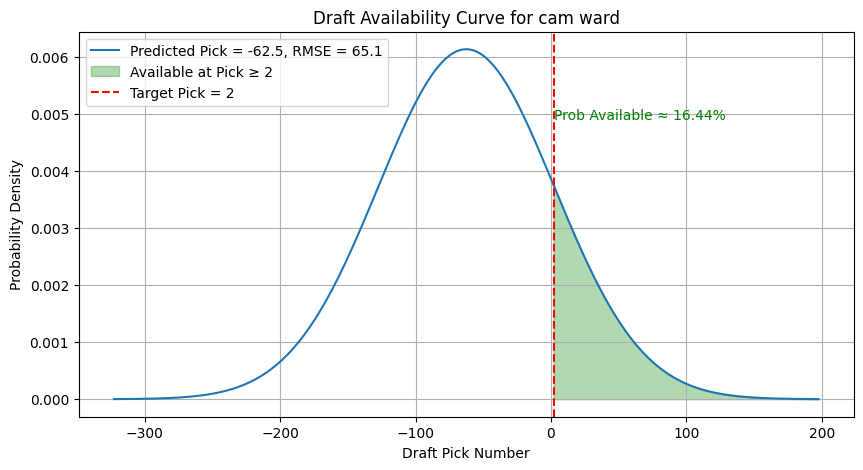

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# -- Define plotting function --
def plot_availability_distribution(predicted_pick, target_pick, rmse, player_name=None):
    x = np.linspace(predicted_pick - 4*rmse, predicted_pick + 4*rmse, 500)
    y = norm.pdf(x, loc=predicted_pick, scale=rmse)

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label=f'Predicted Pick = {predicted_pick:.1f}, RMSE = {rmse:.1f}')
    plt.title(f"Draft Availability Curve for {player_name}" if player_name else "Draft Availability Curve")
    plt.xlabel("Draft Pick Number")
    plt.ylabel("Probability Density")

    # Shaded region: player is still available at or after the target pick
    x_fill = np.linspace(target_pick, x[-1], 500)
    y_fill = norm.pdf(x_fill, loc=predicted_pick, scale=rmse)
    plt.fill_between(x_fill, y_fill, alpha=0.3, color='green', label=f'Available at Pick ≥ {target_pick}')

    # Handle special case: pick 1 should always be 100% available
    if target_pick == 1:
        prob = 1.0
    else:
        prob = 1 - norm.cdf(target_pick - 1, loc=predicted_pick, scale=rmse)

    # Annotate pick line and probability
    plt.axvline(x=target_pick, color='red', linestyle='--', label=f'Target Pick = {target_pick}')
    plt.text(target_pick + 0.5, max(y)*0.8, f"Prob Available ≈ {prob:.2%}", color='green')

    plt.legend()
    plt.grid(True)
    plt.show()


# -- Ask for user input --
player_input = input("Enter a player's name (exactly as in the model): ")
target_pick = int(input("Enter your target pick number: "))

# -- Lookup predicted pick from your 2025 prediction table --
player_row = all_mocks_25[all_mocks_25['Player'].str.lower() == player_input.lower()]

if not player_row.empty:
    predicted_pick = player_row.iloc[0]['predicted_raw']
    plot_availability_distribution(predicted_pick, target_pick, rmse, player_name=player_input)
else:
    print(f"⚠️ Player '{player_input}' not found in mock data.")

#Enter a player's name (exactly as in the model): Cam Ward
#Enter your target pick number: 3